In [1]:
# system and utility imports
import os
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import joblib

# sklearn metrics and utilities
from sklearn.metrics import (
    roc_curve, roc_auc_score, precision_recall_curve, 
    average_precision_score, accuracy_score, confusion_matrix, 
    classification_report, auc, log_loss, precision_score, 
    recall_score, f1_score
)
from sklearn.utils import class_weight, compute_class_weight
from sklearn.model_selection import train_test_split
from skimage.metrics import mean_squared_error
from skimage.metrics import structural_similarity as ssim
from imblearn.over_sampling import SMOTE

# tensorFlow and keras model utilities
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models, optimizers, backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# tensorFlow and keras layers
from tensorflow.keras.layers import (
    Input, Dense, Reshape, Flatten, Dropout, BatchNormalization, 
    Conv2DTranspose, Activation, LeakyReLU, UpSampling2D, 
    Conv2D, MaxPooling2D, ReLU
)

# image preprocessing
from tensorflow.keras.preprocessing.image import (
    load_img, img_to_array, ImageDataGenerator
)

# regularization
from keras.regularizers import l2

# sklearn Model and Hyperparameter Tuning
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [2]:
# function to check if a file is an image
def is_image_file(filename):
    return filename.lower().endswith('.jpg')

In [3]:
# function to load and preprocess an image
def load_and_preprocess_image(img_path, target_size=(128, 128)):
    # load image
    image = Image.open(img_path)
    
    # resize image to target size
    image = image.resize(target_size)
    
    # convert image to array and normalize (pixel values between 0 and 1)
    image = np.array(image) / 255.0
    
    # ensure image has 3 channels (RGB)
    if len(image.shape) == 2:  # If grayscale, convert to RGB
        image = np.stack((image,) * 3, axis=-1)
    elif image.shape[2] == 4:  # If RGBA, convert to RGB
        image = image[:, :, :3]
    
    return image

In [4]:
# function to load images from a directory and assign labels
def load_images_from_directory(directory, label):
    images = []
    labels = []
    for root, _, files in os.walk(directory):
        for file in files:
            if is_image_file(file):
                img_path = os.path.join(root, file)
                image = load_and_preprocess_image(img_path)  # Load and preprocess
                images.append(image)
                labels.append(label)
    return np.array(images), np.array(labels)

In [5]:
# base directory for the dataset
directory = 'vehicle_insurance_dataset'

# set paths for training data subdirectories
train_fraud_dir = os.path.join(directory, 'train', 'fraud')
train_non_fraud_dir = os.path.join(directory, 'train', 'non-fraud')

# load and label the training images for fraud and non-fraud cases
train_images_fraud, train_labels_fraud = load_images_from_directory(train_fraud_dir, 1)
train_images_non_fraud, train_labels_non_fraud = load_images_from_directory(train_non_fraud_dir, 0)

print(f"Train images (fraud) shape: {train_images_fraud.shape}")
print(f"Train labels (fraud) shape: {train_labels_fraud.shape}")
print(f"Train images (non-fraud) shape: {train_images_non_fraud.shape}")
print(f"Train labels (non-fraud) shape: {train_labels_non_fraud.shape}")

Train images (fraud) shape: (372, 128, 128, 3)
Train labels (fraud) shape: (372,)
Train images (non-fraud) shape: (6091, 128, 128, 3)
Train labels (non-fraud) shape: (6091,)


In [6]:
# reshape the image data for SMOTE
fraud_images_flat = train_images_fraud.reshape(train_images_fraud.shape[0], -1)
non_fraud_images_flat = train_images_non_fraud.reshape(train_images_non_fraud.shape[0], -1)

# create labels for fraud (1) and non-fraud (0)
fraud_labels = np.ones(train_images_fraud.shape[0])
non_fraud_labels = np.zeros(train_images_non_fraud.shape[0])

# combine images and labels
combined_images_flat = np.vstack((fraud_images_flat, non_fraud_images_flat))
combined_labels = np.hstack((fraud_labels, non_fraud_labels))

In [7]:
# load the SMOTE model from the file using joblib
smote_loaded = joblib.load('smote_model.pkl')

In [8]:
# apply SMOTE to oversample the fraud class in the training data
X_resampled, y_resampled = smote_loaded.fit_resample(combined_images_flat, combined_labels)

# separate resampled fraud and non-fraud images
X_fraud_resampled = X_resampled[y_resampled == 1]
X_non_fraud_resampled = X_resampled[y_resampled == 0]

# reshape the resampled fraud images and the original non-fraud images back into the image shape
image_height, image_width, image_channels = train_images_fraud.shape[1], train_images_fraud.shape[2], train_images_fraud.shape[3]
X_fraud_resampled_images = X_fraud_resampled.reshape(-1, image_height, image_width, image_channels)
X_non_fraud_resampled_images = X_non_fraud_resampled.reshape(-1, image_height, image_width, image_channels)

# combine resampled fraud images and non-fraud images
X_train_balanced = np.vstack((X_fraud_resampled_images, X_non_fraud_resampled_images))
y_train_balanced = np.hstack((np.ones(X_fraud_resampled_images.shape[0]), np.zeros(X_non_fraud_resampled_images.shape[0])))

# display the shapes of the balanced data
print(f"Balanced train images shape: {X_train_balanced.shape}")
print(f"Balanced train labels shape: {y_train_balanced.shape}")

Balanced train images shape: (12182, 128, 128, 3)
Balanced train labels shape: (12182,)


In [9]:
# function to denoise
def denoise_images_with_dcae(fraud_images, non_fraud_images, dcae_model_path):
    # load the DCAE model for denoising
    dcae_model = load_model(dcae_model_path)
    print("DCAE model loaded.")

    # denoising fraud and non-fraud images
    fraud_images_denoised = dcae_model.predict(fraud_images)
    non_fraud_images_denoised = dcae_model.predict(non_fraud_images)

    # print the shape of the denoised datasets
    print(f"Denoised Fraud dataset shape: {fraud_images_denoised.shape}")
    print(f"Denoised Non-Fraud dataset shape: {non_fraud_images_denoised.shape}")

    return fraud_images_denoised, non_fraud_images_denoised

In [10]:
# denoise the balanced fraud and non-fraud images
fraud_images_denoised, non_fraud_images_denoised = denoise_images_with_dcae(
    X_fraud_resampled_images,  # combined original + SMOTE-generated fraud images
    X_non_fraud_resampled_images,  # original non-fraud images from the training data
    'dcae_model.keras'  # DCAE model path
)

DCAE model loaded.
191/191 ━━━━━━━━━━━━━━━━━━━━ 28s 145ms/step
191/191 ━━━━━━━━━━━━━━━━━━━━ 28s 144ms/step
Denoised Fraud dataset shape: (6091, 128, 128, 3)
Denoised Non-Fraud dataset shape: (6091, 128, 128, 3)


In [11]:
# combine denoised fraud and non-fraud images
balanced_images_denoised = np.vstack((fraud_images_denoised, non_fraud_images_denoised))

# combine labels for fraud (1) and non-fraud (0) as they were defined earlier
balanced_train_labels_denoised = np.hstack((np.ones(fraud_images_denoised.shape[0]), np.zeros(non_fraud_images_denoised.shape[0])))

# shuffle both images and labels together
indices = np.arange(balanced_images_denoised.shape[0])
np.random.shuffle(indices)

balanced_images_denoised = balanced_images_denoised[indices]
balanced_train_labels_denoised = balanced_train_labels_denoised[indices]

# verify the shape of the shuffled and combined datasets
print(f"Combined Fraud & Non-Fraud train dataset shape: {balanced_images_denoised.shape}")
print(f"Combined Fraud & Non-Fraud train label dataset shape: {balanced_train_labels_denoised.shape}")

Combined Fraud & Non-Fraud train dataset shape: (12182, 128, 128, 3)
Combined Fraud & Non-Fraud train label dataset shape: (12182,)


In [12]:
# define the parameter grid for Random Forest
param_dist = {
    'n_estimators': [25, 50],  
    'max_depth': [10, 15],  
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

In [13]:
# class labels
class_labels = np.array([0, 1])  # 0 is non-fraud, 1 is fraud

# calculate the class weights based on the training labels
class_weights = compute_class_weight('balanced', classes=class_labels, y=balanced_train_labels_denoised)

# create a dictionary for class weights
class_weight_dict = {0: 1, 1: 1.0} 

# initialize the Random Forest model and pass this dictionary to GridSearchClassifier
rf_classifier = RandomForestClassifier(random_state=42, class_weight=class_weight_dict)
print(f"Random Forest model initialized with class weights: {class_weight_dict}")

Random Forest model initialized with class weights: {0: 1, 1: 1.0}


In [14]:
# flatten the images for Random Forest, if necessary
X_flat = balanced_images_denoised.reshape(balanced_images_denoised.shape[0], -1) 
y_flat = balanced_train_labels_denoised 

# use the full dataset (no test split)
X_train_flat, y_train_flat = X_flat, y_flat

In [15]:
# initialize GridSearchCV with the parameter grid
grid_search = GridSearchCV(
    estimator=rf_classifier, 
    param_grid=param_dist, 
    cv=2,  # 3-fold cross-validation
    verbose=2, 
    n_jobs=2
)

# Fit RandomizedSearchCV on the training data
grid_search.fit(X_train_flat, y_train_flat)

# retrieve the best parameters and model
best_rf_classifier = grid_search.best_estimator_
print("Best Parameters:", best_rf_classifier)

# save the model to a file
joblib.dump(best_rf_classifier, 'smote_best_rf_classifier.pkl')
print("Model saved as smote_best_rf_classifier.pkl")

# test the best model on the test set
test_accuracy = best_rf_classifier.score(X_flat, y_flat)
print(f"Test Accuracy: {test_accuracy}")

Fitting 2 folds for each of 32 candidates, totalling 64 fits
Best Parameters: RandomForestClassifier(class_weight={0: 1, 1: 1.0}, max_depth=15,
                       max_features='log2', n_estimators=50, random_state=42)
Model saved as smote_best_rf_classifier.pkl
Test Accuracy: 0.9785749466425874


In [16]:
# predictions on the test set (validation set)
y_pred = best_rf_classifier.predict(X_flat)
y_pred_proba = best_rf_classifier.predict_proba(X_flat)[:, 1] 

# print performance metrics
print("Accuracy: ", accuracy_score(y_flat, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_flat, y_pred))
print("Classification Report:\n", classification_report(y_flat, y_pred))

Accuracy:  0.9785749466425874
Confusion Matrix:
 [[5830  261]
 [   0 6091]]
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.96      0.98      6091
         1.0       0.96      1.00      0.98      6091

    accuracy                           0.98     12182
   macro avg       0.98      0.98      0.98     12182
weighted avg       0.98      0.98      0.98     12182



In [17]:
# set paths to the test directories
test_fraud_dir = os.path.join(directory, 'test','fraud')
test_non_fraud_dir = os.path.join(directory,'test', 'non-fraud')

# load and label the test images
test_images_fraud, test_labels_fraud = load_images_from_directory(test_fraud_dir, 1)
test_images_non_fraud, test_labels_non_fraud = load_images_from_directory(test_non_fraud_dir, 0)

print(f"Test images fraud shape: {test_images_fraud.shape}")
print(f"Test fraud labels shape: {test_labels_fraud.shape}")

print(f"Test images non_fraud shape: {test_images_non_fraud.shape}")
print(f"Test non_fraud labels shape: {test_labels_non_fraud.shape}")

Test images fraud shape: (93, 128, 128, 3)
Test fraud labels shape: (93,)
Test images non_fraud shape: (1523, 128, 128, 3)
Test non_fraud labels shape: (1523,)


In [18]:
# combine the test images and labels and shuffle
test_images = np.concatenate((test_images_fraud, test_images_non_fraud), axis=0)
test_labels = np.concatenate((test_labels_fraud, test_labels_non_fraud), axis=0)

# shuffle the test data rabdomly to prevent bias durign testing
indices = np.arange(test_images.shape[0]) # generate an array of indices representing the positions of the samples
np.random.shuffle(indices) # shuffle the indices randomly

# reorder the images and labels according to the shuffled indices
test_images = test_images[indices]
test_labels = test_labels[indices]

print(f"Combined test images: {test_images.shape}")
print(f"Combined test labels: {test_labels.shape}")

Combined test images: (1616, 128, 128, 3)
Combined test labels: (1616,)


In [19]:
# denoise the test images using the DCAE model
dcae_model = load_model('dcae_model.keras')
denoised_test_images = dcae_model.predict(test_images)

# verify the shape of the denoised images
print(f"Denoised Test Images Shape: {denoised_test_images.shape}")

51/51 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step
Denoised Test Images Shape: (1616, 128, 128, 3)


In [20]:
# load the saved Random Forest model
best_rf_classifier = joblib.load('smote_best_rf_classifier.pkl')
print("Model loaded successfully.")

# flatten the denoised test images for the Random Forest model
flattened_test_images = denoised_test_images.reshape(denoised_test_images.shape[0], -1)  # flatten to shape (num_samples, 128*128*3)

# predict labels using the denoised test images
test_probs = best_rf_classifier.predict(flattened_test_images)
print(f"Predicted Labels: {test_probs}")

# generate and print the classification report and confusion matrix
print("Classification Report:\n", classification_report(test_labels, test_probs))
print("Confusion Matrix:\n", confusion_matrix(test_labels, test_probs))

Model loaded successfully.
Predicted Labels: [0. 0. 0. ... 0. 0. 0.]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.93      0.94      1523
           1       0.22      0.35      0.28        93

    accuracy                           0.89      1616
   macro avg       0.59      0.64      0.61      1616
weighted avg       0.92      0.89      0.90      1616

Confusion Matrix:
 [[1409  114]
 [  60   33]]


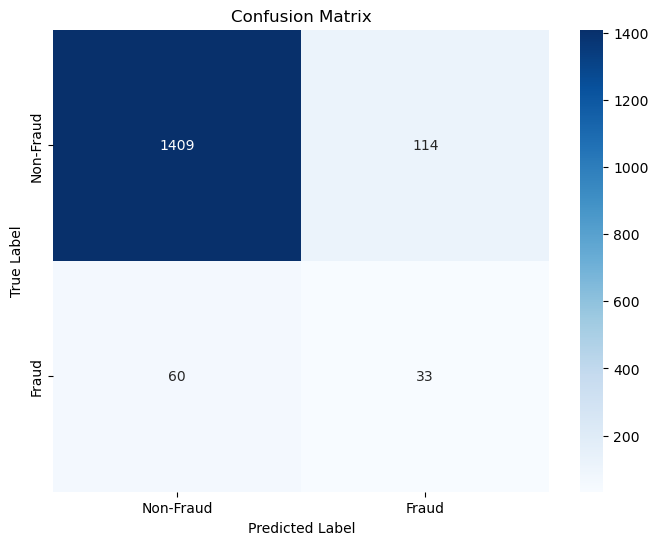

In [21]:
# calculate confusion matrix
cm = confusion_matrix(test_labels, test_probs.round())  

# create a heatmap to visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,  
            xticklabels=['Non-Fraud', 'Fraud'], 
            yticklabels=['Non-Fraud', 'Fraud'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

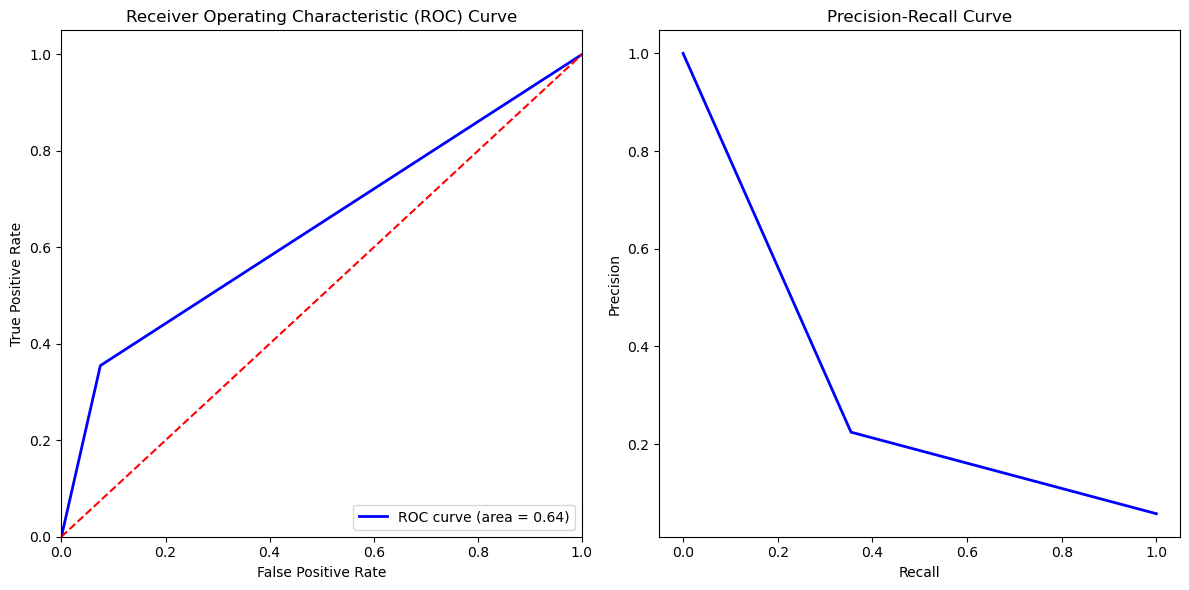

In [22]:
# calculate ROC curve
fpr, tpr, _ = roc_curve(test_labels, test_probs)
roc_auc_value = auc(fpr, tpr)  # Avoid naming conflict by renaming the variable

# calculate Precision-Recall curve
precision, recall, _ = precision_recall_curve(test_labels, test_probs)

# plot ROC curve
plt.figure(figsize=(12, 6))

# ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc_value))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Random guess line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Precision-Recall Curve
plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

plt.tight_layout()
plt.show()

Test Loss: 0.3480
Test Accuracy: 0.8923


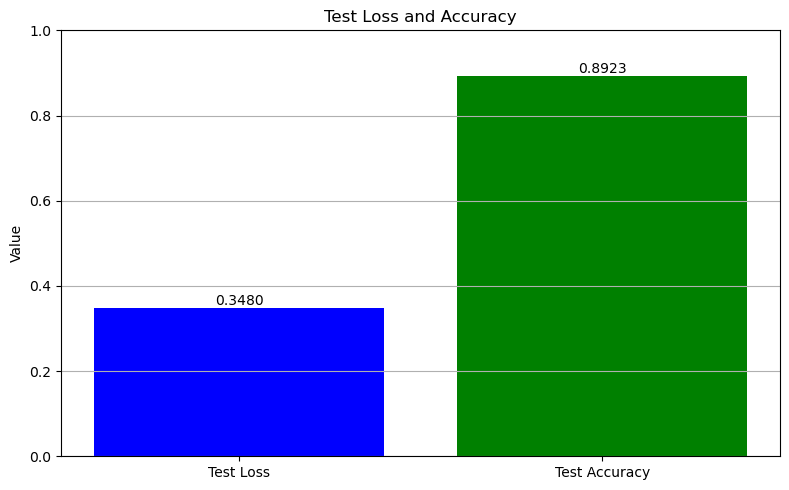

In [23]:
# make predictions on the test set
predicted_probs = best_rf_classifier.predict_proba(flattened_test_images)  # get predicted probabilities
predicted_labels = best_rf_classifier.predict(flattened_test_images)  # get predicted classes

# calculate test accuracy and loss
test_accuracy = accuracy_score(test_labels, predicted_labels)
test_loss = log_loss(test_labels, predicted_probs)

# display the test loss and accuracy
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# data for plotting
metrics = ['Test Loss', 'Test Accuracy']
values = [test_loss, test_accuracy]

# create a bar chart
plt.figure(figsize=(8, 5))
bars = plt.bar(metrics, values, color=['blue', 'green'])

# adding value labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f"{yval:.4f}", ha='center', va='bottom')

# adding title and labels
plt.title('Test Loss and Accuracy')
plt.ylabel('Value')
plt.ylim(0, 1)  # Set y-axis limits

# show the plot
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [24]:
# function to load unlabelled validation images
def load_unalabelled_images_from_directory(directory, label=None):
    images = []
    labels = []
    
    for root, _, files in os.walk(directory):
        for file in files:
            if is_image_file(file):
                image_path = os.path.join(root, file)
                image = load_img(image_path, target_size=(128, 128))  # load image
                image = img_to_array(image)  # convert to array
                images.append(image)
                
                # append label if provided
                if label is not None:
                    labels.append(label)
    
    images = np.array(images)
    
    if label is not None:
        labels = np.array(labels)
        return images, labels
    
    return images

In [25]:
# load validation images from the 'sol' directory
val_dir = os.path.join(directory, 'sol')
val_images = load_unalabelled_images_from_directory(val_dir)

# check if validation images are loaded
if val_images is None or len(val_images) == 0:
    raise ValueError("Validation images could not be loaded. Please check the validation directory, named 'sol'.")
else:
    print(f"Validation images loaded successfully. Shape: {val_images.shape}")

Validation images loaded successfully. Shape: (3462, 128, 128, 3)


In [26]:
# reshape denoised validation images back to original shape (128, 128, 3)
val_images_flattened = val_images.reshape(val_images.shape[0], -1)  # flatten to shape (num_samples, 128*128*3)

# load the classification model
model_name = 'smote_best_rf_classifier.pkl'
classification_model = joblib.load(model_name)
print(f"Model '{model_name}' loaded successfully.")

# predict probabilities for validation images
val_labels = classification_model.predict(val_images_flattened)

# verify the shape of the validation images and predicted labels
print(f"Validation Images Shape (flattened): {val_images_flattened.shape}")
print(f"Predicted Validation Labels Shape: {val_labels.shape}")

# print the predicted labels
print(f"Predicted Validation Labels: {val_labels}")

Model 'smote_best_rf_classifier.pkl' loaded successfully.
Validation Images Shape (flattened): (3462, 49152)
Predicted Validation Labels Shape: (3462,)
Predicted Validation Labels: [0. 0. 0. ... 0. 0. 0.]


In [27]:
# function to get all image paths in a directory
def get_image_paths_from_directory(directory):
    image_paths = []
    for root, _, files in os.walk(directory):
        for file in files:
            if is_image_file(file):
                image_paths.append(os.path.join(root, file))
    return image_paths

In [28]:
# create a DataFrame for the validation predictions
val_image_paths = get_image_paths_from_directory(val_dir)
val_predictions = pd.DataFrame({'image_path': val_image_paths, 'predicted_label': val_labels})

# add a column for fraud and non-fraud labels
val_predictions['classified'] = val_predictions['predicted_label'].apply(lambda x: 'fraud' if x == 1 else 'non-fraud')

print('Fraud count:', val_predictions[val_predictions['predicted_label'] == 1].shape[0])
print('Non_Fraud count:', val_predictions[val_predictions['predicted_label'] == 0].shape[0])

Fraud count: 0
Non_Fraud count: 3462


In [29]:
# export to CSV
val_predictions.to_csv('smote_rf_validation_predictions.csv', index=False)
print("Validation predictions have been exported to smote_rf_validation_predictions.csv")

Validation predictions have been exported to smote_rf_validation_predictions.csv


In [30]:
# function to load and preprocess the images
def load_validated_and_preprocess_image(img_path):
    # load the image
    img = Image.open(img_path)
    # resize to the expected input shape of your CNN
    img = img.resize((128, 128))
    # convert to numpy array and normalize pixel values to [0, 1]
    img_array = np.array(img) / 255.0
    
    return img_array

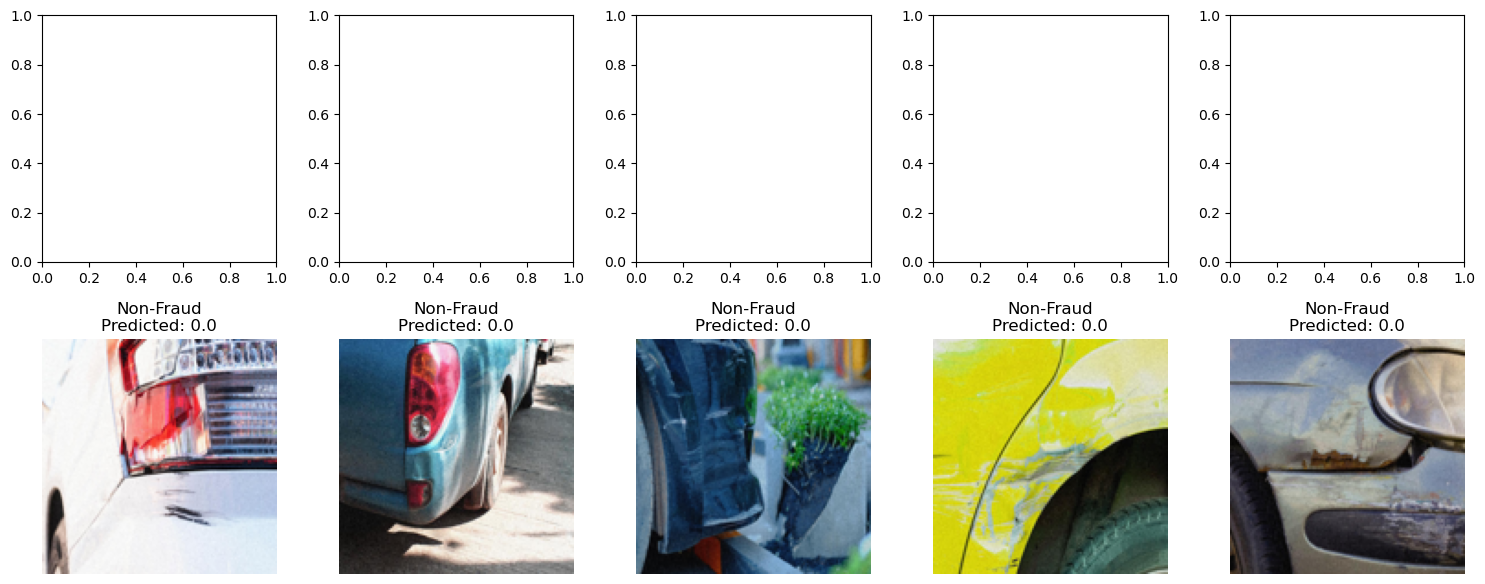

In [31]:
# function to plot fraud and non-fraud images along with their predicted labels
def plot_images(val_predictions, n=5):
    # filter fraud and non-fraud images
    fraud_images = val_predictions[val_predictions['predicted_label'] == 1]
    non_fraud_images = val_predictions[val_predictions['predicted_label'] == 0]
    
    # sample images safely
    num_fraud_samples = min(len(fraud_images), n)
    num_non_fraud_samples = min(len(non_fraud_images), n)

    # randomly sample images
    fraud_sample = fraud_images.sample(num_fraud_samples) if num_fraud_samples > 0 else pd.DataFrame(columns=val_predictions.columns)
    non_fraud_sample = non_fraud_images.sample(num_non_fraud_samples) if num_non_fraud_samples > 0 else pd.DataFrame(columns=val_predictions.columns)

    # create subplots
    fig, axes = plt.subplots(2, n, figsize=(15, 6))
    
    # plot fraud images
    for i, (index, row) in enumerate(fraud_sample.iterrows()):
        img_path = row['image_path']
        img = load_validated_and_preprocess_image(img_path)
        axes[0, i].imshow(img)
        axes[0, i].set_title(f"Fraud\nPredicted: {row['predicted_label']}")
        axes[0, i].axis('off')
    
    # plot non-fraud images
    for i, (index, row) in enumerate(non_fraud_sample.iterrows()):
        img_path = row['image_path']
        img = load_validated_and_preprocess_image(img_path)
        axes[1, i].imshow(img)
        axes[1, i].set_title(f"Non-Fraud\nPredicted: {row['predicted_label']}")
        axes[1, i].axis('off')

    # adjust layout and display
    plt.tight_layout()
    plt.show()

# display a few fraud and non-fraud images
plot_images(val_predictions, n=5)
